In [1]:
# !pip install '../input/myofflinepackage/torch-1.9.0cu102-cp37-cp37m-linux_x86_64.whl'
# !pip install '../input/myofflinepackage/torchvision-0.10.0cu102-cp37-cp37m-linux_x86_64.whl'/

# !pip install python-gdcm
# !pip install torch --upgrade
!pip install timm
!pip install effdet
# !pip install wandb --upgrade
# !pip install madgrad
!pip install git+https://github.com/lessw2020/Ranger21.git

     |████████████████████████████████| 376 kB 4.5 MB/s 
     |████████████████████████████████| 111 kB 4.3 MB/s 
     |████████████████████████████████| 74 kB 1.7 MB/s 
     |████████████████████████████████| 112 kB 6.8 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=f3605fbdb2c9e496e91cab61eec4e33a110b9eb5ec60c8a6ee441e27a0139b71
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272453 sha256=f48d1668ba6028cc316e22d46be2d828096651176e57105f1098efade064b41f
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built antlr4-python3-runtime pycocotools
  Cloning https://github.com/lessw2020/Ranger21.git to /tmp/pip-req-build-n2pqw3hc
  Running command git clone -q https://github.com/lessw2020/Ranger21.

In [2]:
# note
# review StraifiedGroupKFold

# Library

In [3]:
import sys
import numpy as np
import pandas as pd
from glob import glob
import random
from numba import jit
from collections import defaultdict, Counter
from kaggle_secrets import UserSecretsClient
import os
import warnings
from datetime import datetime, timedelta
import time
import gc
from tqdm.notebook import tqdm

# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.cuda.amp import GradScaler, autocast

# from madgrad import MADGRAD

from ranger21 import Ranger21

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.bbox_utils import convert_bbox_to_albumentations, convert_bbox_from_albumentations

import effdet

import ast
import cv2
import torchvision
import torchvision.transforms as T
import timm
# from timm.data.auto_augment import rand_augment_transform, augment_and_mix_transform
from timm.models.efficientnet import *

import wandb
from torchmetrics import AveragePrecision, Accuracy, AUROC

import matplotlib.pyplot as plt
import matplotlib

# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import GroupKFold
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import average_precision_score

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 25)
# %load_ext line_profiler

In [4]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    
print(torch.__version__)

1.7.0


# Configuration

In [5]:
config = {
    'batch_size': 4,
    'seed': 42,
    'num_classes': 4,
    'fold': 5,
    'image_size': 384,
    'num_workers': 4,
    'box_format': 'pascal'
}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# sys.path.insert(0, '../input/sam-optimizer')
sys.path.append('../input/lovaszloss')

# from sam import SAM
from pytorch.lovasz_losses import lovasz_hinge

# Seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(config['seed'])

# Path

In [8]:
# SAMP_SUB = '/content/data/sample_submission.csv'
TRAIN_IMAGE_LEVEL = '../input/siim-covid19-detection/train_image_level.csv'
TRAIN_STUDY_LEVEL = '../input/siim-covid19-detection/train_study_level.csv'
# TRAIN_PATH = '../input/siim-covid19-detection/train'
# TEST_PATH = '../input/siim-covid19-detection/test'


TRAIN_JPG = '../input/siim-covid19-train/siim-covid19-train/train'
TEST_JPG = '../input/siim-covid19-train/siim-covid19-train/test'
MASK_TRAIN = '../input/siim-covid19-train/train_masked/train_masked'
META = '../input/siim-covid19-train/siim-covid19-train/meta.csv'

TDF_PATH = '../input/siim-train-df/train_df.csv'
# TRAIN_DFV2 = '/content/data/train_df_v2.csv'
# DUPLICATES = '../input/siim-train-df/duplicate.txt'
DUPLICATES = '../input/siim-train-df/pairs.csv'

# Setup DataFrame

In [9]:
train_df = pd.read_csv(TDF_PATH)
study_lvl = pd.read_csv(TRAIN_STUDY_LEVEL)
image_lvl = pd.read_csv(TRAIN_IMAGE_LEVEL)
meta = pd.read_csv(META)
duplicates_df = pd.read_csv(DUPLICATES)

# duplicates_images = []
# for idx, row in duplicates_df.iloc[:, 1:].iterrows():
#     duplicates_images.append(row.dropna().tolist())
# duplicates_images = pd.Series(list(zip(*duplicates_images))[0]).apply(lambda row: row[:-6])

duplicates_images = np.squeeze(duplicates_df['image2'].str.extract('../input/siim-covid19-detection/train/.*/.*/(.*).dcm').values)


train_df['integer_label'] = np.argmax(train_df.iloc[:,4:8].values, axis=1)
train_df['ImageInstanceUID'] = train_df['id'].str.split('_').apply(lambda row: row[0])

# get train_jpg path
train_jpg = pd.DataFrame(glob(f'{TRAIN_JPG}/*'), columns=['train_jpg'])
train_jpg['file_name'] = train_jpg.iloc[:,0].str.extract(f'{TRAIN_JPG}/(.*).jpg')

# merge meta info
train_df = train_df.merge(train_jpg, left_on='ImageInstanceUID', right_on='file_name')

# get mask_path
mask_df = pd.DataFrame(glob(f'{MASK_TRAIN}/*.jpg'), columns=['train_mask'])
mask_df['file_name'] = mask_df['train_mask'].str.extract(f'{MASK_TRAIN}/(.*).jpg')
train_df = train_df.merge(mask_df, on='file_name')

meta_train = meta[meta['split'] == 'train'].rename(columns={'dim0':'width', 'dim1':'height'}).drop('split', axis=1)
meta_test = meta[meta['split'] == 'test'].rename(columns={'dim0':'width', 'dim1':'height'}).drop('split', axis=1)

train_df = train_df.merge(meta_train, left_on='ImageInstanceUID', right_on='image_id')

box_format = config['box_format']
bboxes_list = []
for bbox, width, height in zip(train_df['boxes'], train_df['width'], train_df['height']):
    temp = []
    for i in range(8):
        try:
            box = ast.literal_eval(bbox)[i]

            x_min = box['x']
            y_min = box['y']
            x_width = box['width']
            y_height = box['height'] 
            box_coco = [x_min, y_min, x_width, y_height]

            album_format = convert_bbox_to_albumentations(box_coco, 'coco', width, height)
            album_format = np.array(album_format).clip(0., 1.0)
            if box_format == 'pascal':
                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_max = (box['x'] + box['width']) * height_ratio
                # y_max = (box['y'] + box['height']) * width_ratio
                pascal_format = convert_bbox_from_albumentations(album_format, 'pascal_voc', width, height)

                x_min = pascal_format[0]
                y_min = pascal_format[1]
                x_max = pascal_format[2]
                y_max = pascal_format[3]

                box_pascal = [x_min, y_min, x_max, y_max]
                temp.append(box_pascal)
                
            if box_format == 'coco':
                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_width = box['width'] * height_ratio
                # y_height = box['height'] * width_ratio
                coco_format = convert_bbox_from_albumentations(album_format, 'coco', width, height)
                x_min = coco_format[0]
                y_min = coco_format[1]
                x_width = coco_format[2]
                y_height = coco_format[3]

                box_coco = [x_min, y_min, x_width, y_height]
                temp.append(box_coco)
            
            # [class x_center y_center width height] format
            # range of format is 0~1 optimized for yolov5
            if box_format == 'yolo':

                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_max = (box['x'] + box['width']) * height_ratio
                # y_max = (box['y'] + box['height']) * width_ratio
                
                # #n normalize bbox with 512
                # x_center = ((x_min + x_max)/2) / config['image_size']
                # y_center = ((y_min + y_max)/2) / config['image_size']
                # b_width = (x_max - x_min) / config['image_size']
                # b_height = (y_max - y_min) / config['image_size']

                yolo_format = convert_bbox_from_albumentations(album_format, 'yolo', width, height)

                x_center = yolo_format[0]
                y_center = yolo_format[1]
                b_width = yolo_format[2]
                b_height = yolo_format[3]

                box_yolo = [x_center, y_center, b_width, b_height]
                temp.append(box_yolo)
            
        except IndexError:
            pass
        except ValueError:
            temp.append(np.nan)
    if box_format != 'yolo':
        if np.isnan(temp).all():
            temp = [[0.0, 0.0, 1.0, 1.0]]

    bboxes_list.append(temp)

bboxes_df = pd.DataFrame(bboxes_list, columns=[f'box_{i}' for i in range(8)])
train_df = pd.concat([train_df, bboxes_df], axis=1)

# drop weird data 
# not negative and no bbox

not_zeros_df = train_df[train_df['integer_label'] != 0]
drop_row = not_zeros_df[not_zeros_df['boxes'].isnull()].index.values
train_df = train_df.drop(drop_row)

train_df = train_df[~train_df['ImageInstanceUID'].isin(duplicates_images)].reset_index(drop=True)

train_df

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,Opacity,Path,Sex_F,...,train_mask,image_id,width,height,box_0,box_1,box_2,box_3,box_4,box_5,box_6,box_7
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,../input/siim-covid19-detection/train/5776db0c...,0,...,../input/siim-covid19-train/train_masked/train...,000a312787f2,3488,4256,"[789.28836, 582.43035, 1815.94498, 2499.73327]","[2245.91208, 591.20528, 3340.5737, 2352.75472]",None,None,None,None,None,None
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,../input/siim-covid19-detection/train/ff0879eb...,0,...,../input/siim-covid19-train/train_masked/train...,000c3a3f293f,2320,2832,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,../input/siim-covid19-detection/train/9d514ce4...,1,...,../input/siim-covid19-train/train_masked/train...,0012ff7358bc,2544,3056,"[677.42216, 197.97662, 1545.21983, 1197.75876]","[1792.69064, 402.5525, 2409.71798, 1606.910499...",None,None,None,None,None,None
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,1,../input/siim-covid19-detection/train/28dddc85...,1,...,../input/siim-covid19-train/train_masked/train...,001398f4ff4f,3520,4280,"[2729.0, 2181.33331, 3677.00012, 2785.33331]",None,None,None,None,None,None,None
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,../input/siim-covid19-detection/train/dfd9fdd8...,0,...,../input/siim-covid19-train/train_masked/train...,001bd15d1891,2800,3408,"[623.23328, 1050.0, 1337.23328, 2156.0]","[2578.56661, 998.66667, 3241.23328, 2118.66667]",None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0,0,0,../input/siim-covid19-detection/train/7e6c6846...,1,...,../input/siim-covid19-train/train_masked/train...,ffcc6edd9445,4240,3480,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
5972,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0,0,0,../input/siim-covid19-detection/train/8332bdad...,1,...,../input/siim-covid19-train/train_masked/train...,ffd91a2c4ca0,2800,3408,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
5973,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,3,1,../input/siim-covid19-detection/train/7eed9af0...,0,...,../input/siim-covid19-train/train_masked/train...,ffd9b6cf2961,2388,3050,"[2197.38566, 841.07361, 2513.80265, 1292.71119]","[2375.87717, 1830.89015, 2643.6144700000004, 2...","[707.25199, 722.07926, 1099.3924299999999, 157...",None,None,None,None,None
5974,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,2,1,../input/siim-covid19-detection/train/a0cb0b96...,0,...,../input/siim-covid19-train/train_masked/train...,ffdc682f7680,3488,4256,"[2729.2708299999995, 332.26044, 4225.52099, 29...","[1005.8125, 1584.67711, 1668.0416300000002, 23...",None,None,None,None,None,None


# Split

In [10]:
seed_everything(config['seed'])
def stratified_group_k_fold(X, y, groups, k, seed=config['seed']):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [11]:
folds_df = train_df.copy()
seed_everything(config['seed'])

train_x = folds_df.index.values
train_y = folds_df.integer_label.values
groups = folds_df.image_id


for fold, (train_idx, valid_idx) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=5)):
    folds_df.loc[folds_df.iloc[valid_idx].index, 'fold'] = fold

folds_df['fold'] = folds_df['fold'].astype(np.int)
folds_df.groupby(['fold', folds_df.integer_label]).size()

fold  integer_label
0     0                342
      1                568
      2                208
      3                 78
1     0                342
      1                568
      2                208
      3                 78
2     0                342
      1                568
      2                208
      3                 78
3     0                342
      1                567
      2                208
      3                 77
4     0                341
      1                567
      2                208
      3                 78
dtype: int64

# Dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df.reset_index().rename(columns={'index': 'real_image_idx'})
        self.real_image_idx = self.df['real_image_idx']
        self.image_path = df['train_jpg'].tolist()
        self.bbox_path = df[[f'box_{i}' for i in range(8)]]
        self.image_ids = df['image_id']
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_ids = self.df.iloc[idx]['image_id']
        
        # call get images private method
        image = self._get_images(idx)
        bbox = self._get_bbox(idx)
#         image = torch.tensor(self._normalize(image), dtype=torch.float32)
        # capture all targets into dict
        target = {}
        target['labels'] = torch.tensor(self.df['integer_label'].iloc[idx], dtype=torch.int64)
        target['image_idx'] = torch.tensor([self.real_image_idx.tolist()[idx]])
        
        if self.transforms:
            transforms_dict = {
                'image': image,
                'bboxes': bbox,
                'class_labels': [target['labels']] * len(bbox)
            }
            
            transformed = self.transforms(**transforms_dict)
            # replace with transformed image and labels
            image = torch.tensor(transformed['image'], dtype=torch.float32)
            target['bboxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor([target['labels'].item()] * len(target['bboxes']))
            
        return image, target, image_ids
    
    
    def _get_images(self, idx):
        image = cv2.imread(self.image_path[idx])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _get_bbox(self, idx):
        bbox = np.stack(self.bbox_path.iloc[idx].dropna().values)
        return bbox

# Albumentations

In [13]:
def get_train_transforms():
    return A.Compose([
#         A.RandomGamma(always_apply=True),
#         A.CLAHE(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightness(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.Blur(p=0.5),
#         A.RandomResizedCrop(p=0.5, height=config['image_size'], width=config['image_size']),
        A.Cutout(num_holes=10, max_h_size=16, max_w_size=16, p=0.5),
        A.Resize(config['image_size'], config['image_size']),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


def get_valid_transforms():
    return A.Compose([
        A.Resize(config['image_size'], config['image_size']),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Load dataset helper

In [14]:
def get_train_dataset(fold):
    return CustomDataset(df=folds_df[(folds_df['fold'] != fold) & (folds_df['integer_label'] != 0)],
                         transforms=get_train_transforms())

def get_valid_dataset(fold):
    return CustomDataset(df=folds_df[(folds_df['fold'] == fold) & (folds_df['integer_label'] != 0)],
                         transforms=get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

def get_train_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=config['num_workers'],
                      pin_memory=True, sampler=RandomSampler(dataset), collate_fn=collate_fn)

def get_valid_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=config['num_workers'],
                      pin_memory=True, sampler=SequentialSampler(dataset), collate_fn=collate_fn)

In [15]:
train_dataset = get_train_dataset(0)
# valid_dataset = get_valid_dataset(0)

# Draw a sample image from dataset

(tensor([[[145., 147., 147.,  ...,   0.,   0.,   0.],
         [150., 152., 150.,  ...,   0.,   0.,   0.],
         [118., 107.,  98.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[145., 147., 147.,  ...,   0.,   0.,   0.],
         [150., 152., 150.,  ...,   0.,   0.,   0.],
         [118., 107.,  98.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[145., 147., 147.,  ...,   0.,   0.,   0.],
         [150., 152., 150.,  ...,   0.,   0.,   0.],
         [118., 107.,  98.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]]

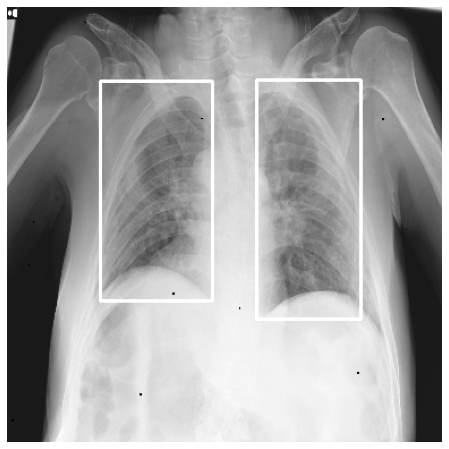

In [16]:
def draw_sample_dataset(dataset, num):
    image, target, image_id = dataset[num]
    print(dataset[num])
    image = np.array(image[0].numpy())
#     image = cv2.imread('../input/siim-covid19-train/siim-covid19-train/train/000a312787f2.jpg')
#     image = cv2.resize(image, (config['image_size'], config['image_size']))
    bboxes = target['bboxes']
    print('image_max: ', image.max(), ' image_min: ', image.min())
    print('image_shape: ', image.shape)
    print('image_id', image_id)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for bbox in bboxes:
        start = (int(bbox[0]), int(bbox[1]))
        end = (int(bbox[2]), int(bbox[3]))
        color = (255, 0, 0)
        cv2.rectangle(image, start, end, color, 2)
    plt.imshow(image, cmap='gray')
    ax.set_axis_off()
    plt.show()


draw_sample_dataset(train_dataset, 0)

# Sample DataLoader

In [17]:
# # # sample train_loaer
# train_loader = get_train_loader(train_dataset, config['batch_size'])
# valid_loader = get_valid_loader(valid_dataset, config['batch_size'])

In [18]:
# images, targets, images_id = next(iter(train_loader))
# images = torch.stack(images).float()
# batch_size = images.shape[0]
# # boxes = [target['boxes'].float() for target in targets]
# labels = torch.tensor([target['labels'].numpy() for target in targets])
# targets_input = [{k: v for k, v in t.items()} for t in targets]

# Meter

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
class Metrics:
    def __init__(self):
        self._reset()
        
    def _reset(self):
        self.step = 0
        self.batch_sum = 0
        
        self.accuracy_sum = 0
        self.proba_list = []
        self.truth_list = []
        self.auroc_sum = 0
        
        self.accuracy = 0
        self.mAP = 0
        self.AUROC = 0
        
        self.acc = Accuracy().to(device)
        self.AP = AveragePrecision(num_classes=config['num_classes']).to(device)
        self.auroc = AUROC(num_classes=config['num_classes']).to(device)
        
    def update(self, y_true_nd, y_true_1d, y_pred_nd, y_pred_1d, batch_num):
        self.step += 1
        self.batch_num = batch_num
        self.batch_sum += batch_num
        
        self.accuracy_sum += self.acc(y_pred_1d, y_true_1d).item()
        self.accuracy = self.accuracy_sum / self.step
  
        self.proba_list.append(y_pred_nd)
        self.truth_list.append(y_true_1d)
        
    def calculate(self):
        self.proba = torch.cat(self.proba_list)
        self.truth = torch.cat(self.truth_list)
        self.mAP = torch.stack(self.AP(self.proba, self.truth)).mean().item()
        self.AUROC = self.auroc(self.proba, self.truth).item()
        
#         self.auroc_sum += self.auroc(y_pred_nd, y_true_1d).item()
#         self.AUROC = self.auroc_sum / self.step
        
        # torch.nan_to_num is not implemented in this version
#         self.mAP_sum += torch.nan_to_num(self.stacked_AP).mean().item()
        
        # set nan to 0.0 might not be the right way to calculate
#         self.stacked_AP[torch.isnan(self.stacked_AP)] = 0.0
#         self.mAP_sum += self.stacked_AP.mean().item()
        
        
    

# Model

In [21]:
def get_effdet(model_name, image_size):
    base_config = effdet.get_efficientdet_config(model_name)
    base_config.image_size = (image_size, image_size)
    
    model = effdet.create_model_from_config(base_config,
                                            bench_task='train',
                                            bench_labeler=True,
                                            num_classes=3,
                                            pretrained=True,)
    return model

# Train

In [22]:
# parameters dacay
# EvalMeter

class Fitter:
    def __init__(self, model, device, config, fold, dry_run=False, wandblogger=False, train_loader_len=None):
        self.model = model
        self.device = device
        self.config = config
        self.fold = fold
        self.wandblogger = wandblogger
        if self.config.accum_grad:
            self.train_loader_len = round(train_loader_len / self.config.accum_iter + 0.1)
        else:
            self.train_loader_len = train_loader_len
        
        self.remain_time = 0
        self.trained_time = 0
        
        self.dry_run = dry_run
        if self.dry_run == True:
            print('==== DRY RUN ====')
            
        if self.wandblogger and not self.dry_run:
            
            wandb.login(key=self.config.wandb_api)
            wandb.init(project="siim-covid19-detection",
                       name=f'f{self.fold}_{self.config.model_name}',
                       group=f'{self.config.model_name}-{self.config.wandblogger_group}',
                       tags=["study"],
                       save_code=True,
                       resume=True)
        
        self.base_dir = f'./outputs/f{self.fold}_{self.config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
            
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        self.epoch = 0
        
        self.criterion = nn.CrossEntropyLoss()
#         self.criterion = self.config.loss_func(**self.config.loss_func_config)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.config.lr, weight_decay=0.001)
#         self.optimizer = MADGRAD(self.model.parameters(), lr=self.config.lr)
#         self.optimizer = optim.SGD(self.model.parameters(), lr=self.config.lr, momentum=0.9, nesterov=True)
#         self.optimizer = self.config.optimizer(self.model.parameters(), **self.config.optim_config, num_batches_per_epoch=self.train_loader_len)
        self.scheduler = self.config.SchedulerClass(self.optimizer, **self.config.scheduler_params)

        self._log(f'Train on device: {self.device}')
        self._log('')
        self._log(f'Fold: {self.fold}/{self.config.fold - 1}')
        self._log(self.config.aug)
        
        if self.config.model_name != 'undefined':
            self._log(f'Model: {self.config.model_name}')
        
        if self.config.accum_grad:
            self._log(f'Gradient Accumulation: {self.config.accum_iter}')
        self.scaler = GradScaler(enabled=self.config.use_apex)
        
    def fit(self, train_loader, validation_loader):
        for epoch in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self._log(f'\n{timestamp}\nLR: {lr}')
                
            t = time.time()
            train_loss = self._train_one_epoch(train_loader)
            
            if epoch == 0:
                self.best_summary_loss = train_loss.avg
                
            train_time = time.time() - t
            self._log(f'[RESULT]: Train. Epoch: {self.epoch + 1}/{self.config.n_epochs}, ' + \
                      f'summary_loss: {train_loss.avg:.5f}, ' + \
                      f'time: {train_time:.5f}')
            self._save(f'{self.base_dir}/last-checkpoint.pth', last=True)
            
            t = time.time()
            valid_loss = self._validation(validation_loader)
            
            valid_time = time.time() - t
            self._log(f'[RESULT]: Valid. Epoch: {self.epoch + 1}/{self.config.n_epochs}, ' + \
                      f'summary_loss: {valid_loss.avg:.5f}, ' + \
                      f'time: {valid_time:.5f}')

            
            if self.wandblogger and not self.dry_run:
                wandb.log({"train/loss": train_loss.avg,
                           "train/lr": lr,
                           "val/loss": valid_loss.avg,
                           })
                
        
            if valid_loss.avg < self.best_summary_loss:
                self.best_summary_loss = valid_loss.avg
                self.model.eval()
                self._save(f'{self.base_dir}/best-loss.pth')
                self._log(f'[SAVED] Epoch: {self.epoch + 1} best-loss: {self.best_summary_loss:.5f}')
            
            if self.config.validation_scheduler:
                self.scheduler.step()
            
            self.epoch += 1
            
            mins_per_epoch = (train_time + valid_time)
            total_time_hrs = (mins_per_epoch * (self.config.n_epochs))
            
            self.trained_time += mins_per_epoch
            self.remain_time = total_time_hrs - self.trained_time
            
            self._log(f'[TIME]: Trained: {timedelta(seconds=self.trained_time)}, ETA: {timedelta(seconds=self.remain_time)}')
            
            # for test
            if self.dry_run:
                if self.epoch == 1:
                    break
            gc.collect()        
            torch.cuda.empty_cache()
            
    def _validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        
        t = time.time()
        for step, (images, targets, imaage_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step + 1}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}, ' + \
                        f'[{(step + 1)/(time.time() - t):.2f}it/s]', end='\r'
                        )
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            bboxes = [target['bboxes'].to(self.device) for target in targets]
            labels = [target['labels'].to(self.device) for target in targets]
            
            valid_target = {}
            valid_target['bbox'] = bboxes
            valid_target['cls'] = labels  
            valid_target["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
            valid_target["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)
                    
            with torch.no_grad():
                outputs = self.model(images, valid_target)
                loss = outputs['loss']
                                    
            summary_loss.update(loss.detach().item(), batch_size)

            # for test  
            if self.dry_run:
                if step == 0:
                    break
                    
        return summary_loss
    
    def _train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        
        t = time.time()
        
        for step, (images, targets, image_ids) in enumerate(train_loader):
            target_res = {}
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step + 1}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}, ' + \
                        f'[{(step + 1)/(time.time() - t):.2f}it/s]', end='\r'
                        )
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            bboxes = [target['bboxes'].to(self.device) for target in targets]
            labels = [target['labels'].to(self.device) for target in targets]
            
            train_target = {}
            train_target['bbox'] = bboxes
            train_target['cls'] = labels

            with autocast(enabled=self.config.use_apex):
                outputs = self.model(images, train_target)
                loss = outputs['loss']
                
            if self.config.accum_grad: 
                loss = loss / self.config.accum_iter
                self.scaler.scale(loss).backward()
                
                if ((step + 1) % self.config.accum_iter == 0) or (step + 1 == len(train_loader)):
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad(set_to_none=True)
                    
                    summary_loss.update(loss.detach().item() * self.config.accum_iter, batch_size)
                
            else:
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)
                
                summary_loss.update(loss.detach().item(), batch_size)
            
            # for test
            if self.dry_run:
                if step == 0:
                    break
                    
        return summary_loss
    
    def _save(self, path, last=False):
        self.model.eval()
        if last:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
    #             'schedular_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
#                 'best_score': self.best_score,
                'epoch': self.epoch,
            }, path)
        else:
            torch.save({
                'model_state_dict': self.model.state_dict(),
    #             'optimizer_state_dict': self.optimizer.state_dict(),
    #             'schedular_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
#                 'best_score': self.best_score,
                'epoch': self.epoch,
            }, path)
        

            
    def load(self, path, last=False):
        checkpoint = torch.load(path, map_location=self.device)
        if last:
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.best_summary_loss = checkpoint['best_summary_loss']
#             self.best_score = checkpoint['best_score']
#             self.epoch = checkpoint['epoch']
        else:
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.best_summary_loss = checkpoint['best_summary_loss']
#             self.best_score = checkpoint['best_score']
#             self.epoch = checkpoint['epoch']
        self._log('[LOADED STATE DICT]')
    
    def _log(self, message):
        print(message)
        with open(self.log_path,'a+') as logger:
            logger.write(f'{message}\n')

In [23]:
class TrainConfig:
    num_workers = config['num_workers']
    batch_size = config['batch_size']
    n_epochs = 10
    lr = 0.001
    # can set lower than this on resume-model
    fold = config['fold']
    aug =  str(get_train_transforms())
    verbose = True
    verbose_step = 1
    
    model_name = 'undefined'
    folder = 'effnetv2_l21k'
    wandblogger_group = 'undefined'
    
    user_secrets = UserSecretsClient()
    wandb_api = user_secrets.get_secret("wandb_api")
    
    validation_scheduler = False
    use_apex = False
    
    accum_grad = True
    accum_iter = 8
    
    masked_size = 32
    
#     SchedulerClass = optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=3,
#         verbose=False,
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0,
#         min_lr=1e-6,
#         eps=1e-08
#     )
    
#     SchedulerClass = optim.lr_scheduler.CosineAnnealingLR
#     scheduler_params = dict(
#         T_max=n_epochs,
#         eta_min=0,
#         last_epoch=-1,
#         verbose=False
    
#     )

    SchedulerClass = optim.lr_scheduler.StepLR
    scheduler_params = dict(
        step_size=5,
        gamma=0.1
    )

    optimizer = Ranger21
    optim_config = dict(
        lr=lr,
        lookahead_active=True,
        use_madgrad=False,
#         weight_decay=0,
        using_gc=True,
        using_normgc=True,
        normloss_active=True,
        softplus=True,
        use_adaptive_gradient_clipping=True,
        num_epochs=n_epochs,
        warmdown_active=False,
        
    )

In [24]:
unique_group_id = wandb.util.generate_id()
TrainConfig.wandblogger_group = unique_group_id
# TrainConfig.wandblogger_group = '78eqbwci'

def run_training(dry_run=False, wandblogger=True):
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    TrainConfig.model_name = 'tf_efficientdet_lite0'
#     for fold in range(config['fold']):
    fold = 0
    net = get_effdet(TrainConfig.model_name, config['image_size'])
    net.to(device)
    train_dataset = get_train_dataset(fold)
    valid_dataset = get_valid_dataset(fold)
    
    config['batch_size'] = 2 # 4x8
    
    if dry_run:
        config['batch_size'] = 2
    
    train_loader = get_train_loader(train_dataset, config['batch_size'])
    valid_loader = get_valid_loader(valid_dataset, config['batch_size'])
    
    train_loader_len = len(train_loader)
    
    fitter = Fitter(model=net, device=device, config=TrainConfig, fold=fold, dry_run=dry_run, wandblogger=wandblogger, train_loader_len=train_loader_len)
#     fitter.load(path=None)
    fitter.fit(train_loader, valid_loader)

In [25]:
run_training(dry_run=False, wandblogger=False)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_lite0-f5f303a9.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_lite0-f5f303a9.pth


Train on device: cpu

Fold: 0/4
Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  RandomBrightness(always_apply=False, p=0.5, limit=(-0.2, 0.2)),
  Rotate(always_apply=False, p=0.5, limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
  Blur(always_apply=False, p=0.5, blur_limit=(3, 7)),
  Cutout(always_apply=False, p=0.5, num_holes=10, max_h_size=16, max_w_size=16),
  Resize(always_apply=False, p=1, height=384, width=384, interpolation=1),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['class_labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Model: tf_efficientdet_lite0
Gradient Accumulation: 8

2021-07-23T02:15:28.000734
LR: 0.001
[RESULT]: Train. Epoch: 1/10, summary_loss: 1.23432, time: 2135.19836
[RESULT]: Valid. Epoch: 1/10, summary_loss: 1.10992, time: 139.32954
[SAVED] Epoch: 1 best-loss: 1.10

In [26]:
wandb.finish()

In [27]:
# {'bbox': [tensor([[234.4223, 179.4036, 430.9095, 285.1888]]), tensor([[296.2383,  44.7257, 486.2206, 317.2470],
#         [ 76.0718, 145.9290, 135.2564, 389.3461]])], 'cls': [tensor([2]), tensor([1, 1])]}